In [22]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
boston = load_boston()
X = boston.data
Y = boston.target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=51)

In [8]:
print(X.shape, Y.shape)

(506, 13) (506,)


Нужно построить градиентный бустинг для 50 деревьев DecisionTreeRegressor(max_depth=5, random_state=42) на датасете. Каждое новое дерево обучается на антиградиенте ошибки композии по прошлым деревьям. Ошибка в этом случае считается как квадрат отклонения предсказания композиции от истинного ответа. Значит, что бы обучать каждое новое дерево нужно считать градиент квадратичной функции потерь. Далее, после обучения нового дерева его нужно с неким коэффициентом добавить в композицию. После 50 итераций это и будет наш бустинг.

In [9]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)])
                for x in X]

Для каждого элемента в выборке  считается сумма предсказаний алгоритма algo из массива алгоритмов base_algorithms_list вместе коэффициентами из массива coefficients_list. Что бы нам посчитать градиенты, нам нужны ответы и предсказания композиции для прошлого шага. 

In [11]:
base_algorithms_list = []
coefficients_list = []
#Эта функция будет возвращать пересчитанный антиградиент композиции. 
def get_grad():
    return [y - a for a, y in zip(gbm_predict(X_train), y_train) ]
    #or more simple return y_train - gbm_predict(X_train)

Теперь нужно обучить 50 деревьев на этих градиентах:

In [14]:
for i in np.arange(0, 50):
    #create new algorithm 
    rg = DecisionTreeRegressor(random_state=42, max_depth=5)
    #fit algo in train dataset and new target
    rg.fit(X_train, get_grad())
    #append results    
    base_algorithms_list.append(rg)
    coefficients_list.append(0.9)
    

In [15]:
pred = gbm_predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))  

5.569226762770745

Давайте посмотрим, как справится с этой задачей нормальный градиентный бустинг.

In [17]:
from xgboost import XGBRegressor

xbg = XGBRegressor(n_estimators=50, max_depth=5)
xbg.fit(X_train, y_train)
pred = xbg.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))


3.8540685511780386

Давайте понаблюдаем, как результат будет зависеть от числа деревьев и глубины

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

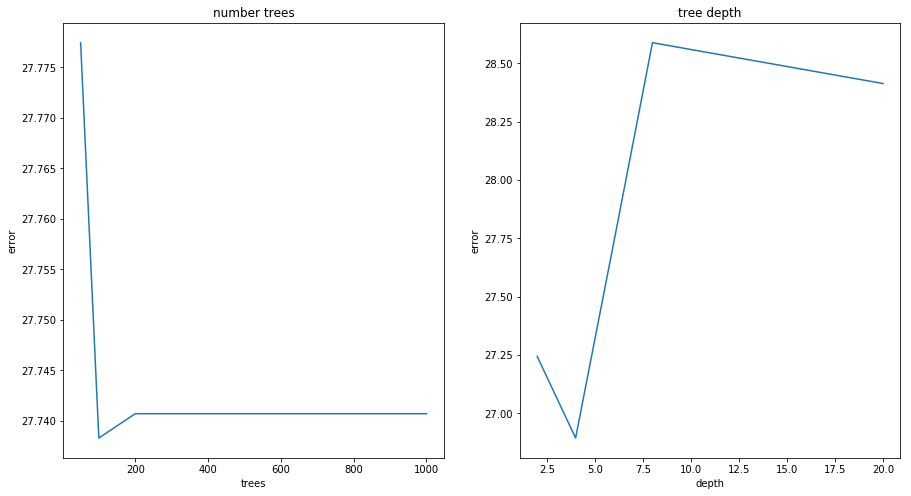

In [23]:
def test_xbg():
    plt.figure(figsize=(15,8))
    
    trees = [50, 100, 200, 300, 400, 500, 1000]
    errors = []
    for tree in trees:
        errors.append(
                -cross_val_score(XGBRegressor(n_estimators=tree), X, Y,  scoring='neg_mean_squared_error').mean()
        )
    plt.subplot(121)
    plt.plot(trees, errors)
    plt.xlabel("trees")
    plt.ylabel("error")
    plt.title("number trees")
    
    depth = [2, 4, 6, 8, 20]
    errors = []
    for d in depth:
        errors.append(
                -cross_val_score(XGBRegressor(max_depth=d), X, Y,  scoring='neg_mean_squared_error').mean()
        )
    plt.subplot(122)
    plt.plot(depth, errors)
    plt.xlabel("depth")
    plt.ylabel("error")
    plt.title("tree depth")    
    plt.show()
test_xbg()

Из графиков видно, что алгоритм сильно переобучается с ростом глубины дерева. Примерно тоже самое наблюдается для числа деревьев. Т.е. рекомендации простые - аккуратно увеличивать число деревьев и их глубину пока это будет снижать ошибку. 